In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.datasets.mnist import load_data

In [2]:
(x_train, y_train), (x_test, y_test) = load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

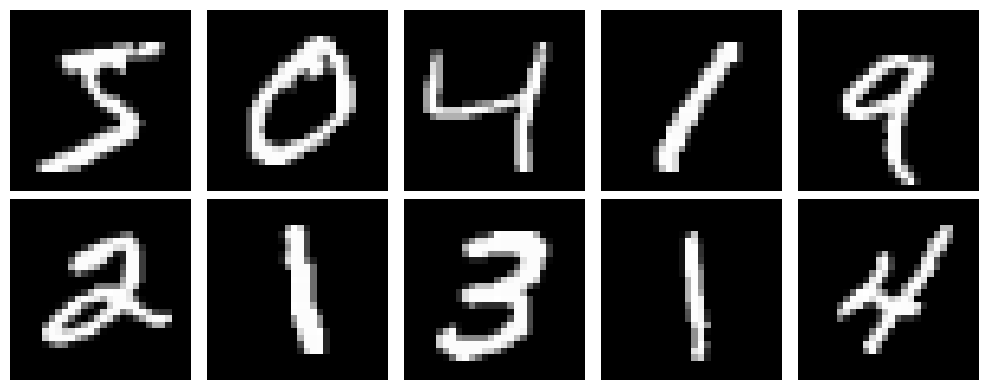

In [3]:
def plot_samples(data):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(data[i], cmap = "gray")
        ax.axis("off")
    fig.tight_layout()

plot_samples(x_train)

In [4]:
# plot_samples(x_train[50000])
x_train[50000].shape

(28, 28)

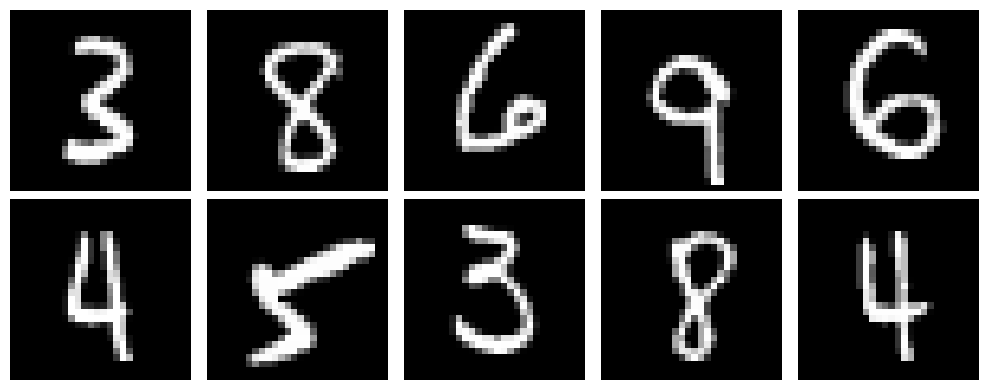

In [5]:
plot_samples(x_train[50000:50010])

In [6]:
X_train = x_train.astype("float32")/255
X_test = x_test.astype("float32")/255
X_train.min(), X_train.max()

(0.0, 1.0)

## Train|Val|Test split

In [14]:
from sklearn.model_selection import train_test_split

# we already have xtrain: 60000 samples
# xtrain val: 50000 samples -> training apart for validation and hyperparameter tuning
# xval: 10000 samples -> validation used for hyperparameter tuning and validation loss curves
# train on trainval and validate on val to hyperparameter tune then when finished train on whole training dataset
X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=1/6, random_state=42)

In [15]:
X_train_val.shape, X_val.shape

((50000, 28, 28), (10000, 28, 28))

In [17]:
# we will use image data generator to augment our data
# it requires rank 4 - number of "features" those above are rank 3
X_train_val[..., None].shape

(50000, 28, 28, 1)

In [18]:
X_train_val= X_train_val[..., None]
X_train= X_train[..., None]
X_val= X_val[..., None]
X_test= X_test[..., None]

## Data augmentation

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_image_generator= ImageDataGenerator(rotation_range= 90)

# batch size 32 - used for mini-batch gradiant descent which gives stochasticity in backpropagation
# flow is used for regenerating images after it has been exhausted
# this is because we will train in many epochs
train_generator= train_image_generator.flow(X_train, y_train, batch_size= 32)

train_generator

In [21]:
# this is the first batch
train_generator[0][0].shape

(32, 28, 28, 1)

In [22]:
# second batch
train_generator[1][0].shape

(32, 28, 28, 1)

In [23]:
# labels for second batch
train_generator[1][1].shape

(32,)

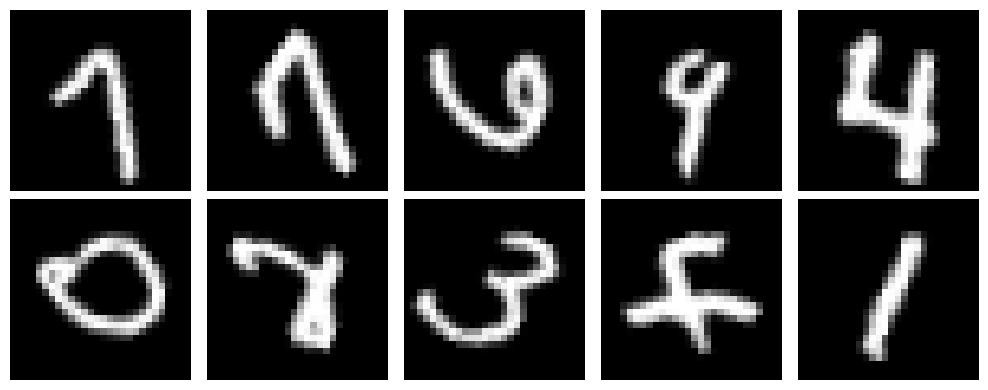

In [25]:
plot_samples(next(train_generator)[0])

## Make a good augmentation

In [26]:
train_image_generator = ImageDataGenerator(
    rotation_range=10,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=False,
    height_shift_range=0.2,
    width_shift_range=0.2,
)

# don't augment test data and validation data - want to test on original data
# this is used for mini-batch in training
test_image_generator = ImageDataGenerator()

train_generator = train_image_generator.flow(X_train, y_train, batch_size=32)
train_val_generator = train_image_generator.flow(X_train_val, y_train_val, batch_size=32)
val_generator = test_image_generator.flow(X_val, y_val, batch_size=32)

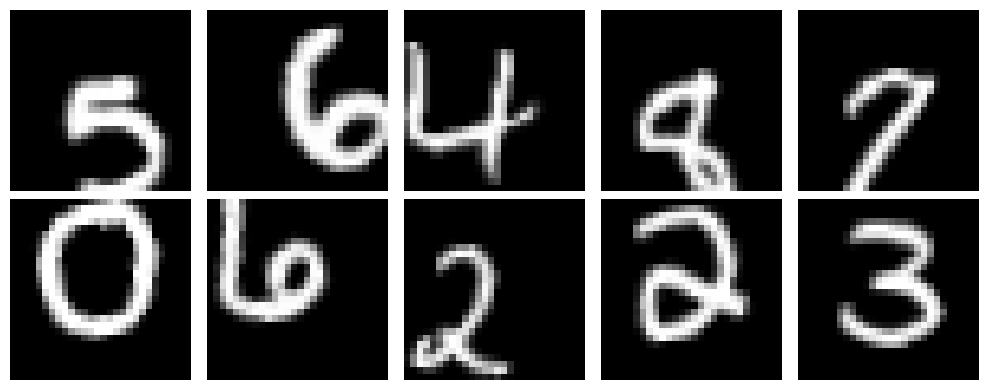

In [27]:
plot_samples(next(train_generator)[0])

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam

def CNN_model(learning_rate=0.001, drop_rate=0.5, kernels=[32, 32]):
    adam = Adam(learning_rate=learning_rate)

    model = Sequential(name="CNN_model")

    for number_kernel in kernels:
        conv_layer = Conv2D(
            number_kernel,
            kernel_size=(3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            input_shape=X_train.shape[1:],
        )

        model.add(conv_layer)
        # defaults to pool_size if None
        model.add(MaxPooling2D(pool_size=(2, 2), strides = 2))

    #MLP part
    model.add(Flatten())
    model.add(Dropout(drop_rate))
    model.add(Dense(256, activation="relu", kernel_initializer="he_normal"))
    model.add(Dense(10, activation="softmax"))

    model.compile(
        loss="sparse_categorical_crossentropy", optimizer=adam, metrics=["acc"]
    )

    return model

model = CNN_model(drop_rate=.5)

model.summary()

c:\Users\milto\Documents\skola\Artificial_Intelligence2-Milton-OPA23\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "CNN_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       205,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,194 (848.41 KB)

 Trainable params: 217,194 (848.41 KB)

 Non-trainable params: 0 (0.00 B)

## Train on augmented data

In [29]:
# number of steps for minibach per epoch
steps_per_epochs= len(X_train_val)//32
validation_steps= len(X_val)//32
steps_per_epochs, validation_steps

# number of batches to be ran in one epoch

(1562, 312)

In [32]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopper = EarlyStopping(
    monitor="val_acc", mode="max", patience=5, restore_best_weights=True
)
model.fit(
    train_val_generator,
    steps_per_epoch=steps_per_epochs,
    epochs=50,
    callbacks=early_stopper,
    validation_data= val_generator, # whis will give us batches for validation
    validation_steps= validation_steps,
)

Epoch 1/50


   7/1562 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - acc: 0.1053 - loss: 2.7330

c:\Users\milto\Documents\skola\Artificial_Intelligence2-Milton-OPA23\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - acc: 0.6569 - loss: 1.0068 - val_acc: 0.9626 - val_loss: 0.1218
Epoch 2/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 23us/step - acc: 0.9375 - loss: 0.1228 - val_acc: 0.9375 - val_loss: 0.0861
Epoch 3/50
   8/1562 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - acc: 0.8974 - loss: 0.3762  

C:\Users\milto\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - acc: 0.9104 - loss: 0.2773 - val_acc: 0.9793 - val_loss: 0.0699
Epoch 4/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 11us/step - acc: 0.9375 - loss: 0.1196 - val_acc: 1.0000 - val_loss: 0.0189
Epoch 5/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - acc: 0.9348 - loss: 0.2084 - val_acc: 0.9818 - val_loss: 0.0615
Epoch 6/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 9us/step - acc: 1.0000 - loss: 0.0199 - val_acc: 1.0000 - val_loss: 0.0011
Epoch 7/50
 491/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - acc: 0.9456 - loss: 0.1813

KeyboardInterrupt: 